In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.axes import Axes

/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
data_dir = 'slopetype.nc'  # daily
ds_soil = xr.open_dataset(data_dir)

data_dir = 'grid_spec.nc'  # daily
ds_grid_spec = xr.open_dataset(data_dir)

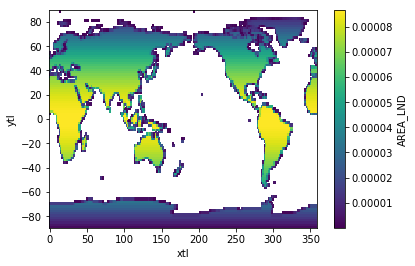

In [3]:
ds_grid_spec.AREA_LND.where(ds_grid_spec.AREA_LND > 0.0).plot()

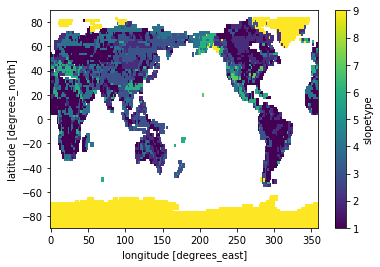

In [5]:
ds_soil.slopetype.where(ds_soil.slopetype > 0.0).plot()

In [6]:
def fill_miss2d(ds, lat_i, lon_j):
# fist cycle
    cycle = 1

    while True:
        bl_i, bl_j = lat_i - cycle, lon_j - cycle
        tr_i, tr_j = lat_i + cycle, lon_j + cycle
        # Bottom left i
        if bl_i < 0:
            bl_i = 0
        # Bottom left j
        if bl_j < 0:
            bl_j = 0
        # Top right i
        if tr_i > ds.lat.shape[0]-1:
            tr_i = ds.lat.shape[0]-1
        # Top right j
        if tr_j > ds.lon.shape[0]-1:
            tr_j = ds.lon.shape[0]-1
        
        lats_i = np.arange(bl_i,tr_i)
        lons_j = np.arange(bl_j,tr_j)
        for lats_i_idx in lats_i:
            for lons_j_idx in lons_j:
                if ds[lats_i_idx, lons_j_idx]>0.0:
                    ds[lat_i, lon_j] = ds[lats_i_idx, lons_j_idx]
                    return
        cycle = cycle + 1

In [7]:
def count_mismatch(ds_grid_spec, ds_data):
    count_lgs_odata = 0.0
    count_ogs_ldata = 0.0
    for i in range(ds_grid_spec.shape[0]):
        for j in range(ds_grid_spec.shape[1]):
            if ds_grid_spec[i,j].values > 0.0 and (not ds_data[i,j].values > 0.0):
                count_lgs_odata = count_lgs_odata + 1.0
            if ds_grid_spec[i,j].values == 0.0 and (not ds_data[i,j].values == 0.0):
                count_ogs_ldata = count_ogs_ldata + 1 
    return count_lgs_odata, count_ogs_ldata

In [8]:
def fill_mismatch(ds_grid_spec, ds_data):
    ds_data_o = ds_data.copy()
    count = 0.0
    for i in range(ds_grid_spec.shape[0]):
        for j in range(ds_grid_spec.shape[1]):
            if ds_grid_spec[i,j].values > 0.0 and (not ds_data[i,j] > 0.0):
                count = count + 1.0
                fill_miss2d(ds_data_o, i, j)
            if ds_grid_spec[i,j].values == 0.0 and (not ds_data[i,j].values == 0.0):
                count = count + 1.0
                ds_data_o[i,j] = 0.0
    return ds_data_o

In [10]:
ds_slopetype_o = fill_mismatch(ds_grid_spec.AREA_LND, ds_soil.slopetype)

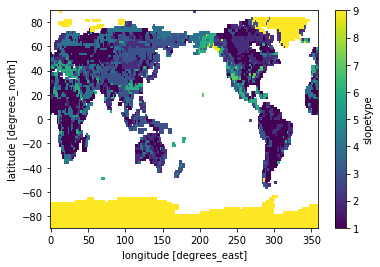

In [11]:
ds_slopetype_o.where(ds_slopetype_o > 0.0).plot()

In [12]:
count_lgs_odata,count_ogs_ldata = count_mismatch(ds_grid_spec.AREA_LND, ds_slopetype_o)
print(count_lgs_odata,count_ogs_ldata)

0.0 0.0


In [13]:
count_lgs_odata,count_ogs_ldata = count_mismatch(ds_grid_spec.AREA_LND, ds_soil.slopetype)
print(count_lgs_odata,count_ogs_ldata)

115.0 251.0


In [14]:
ds_soil['slopetype'] = ds_slopetype_o

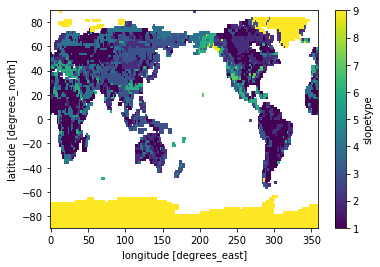

In [15]:
ds_soil.slopetype.where(ds_soil.slopetype > 0.0).plot()

In [16]:
ds_soil.to_netcdf('slopetype_grid_spec.nc')

In [17]:
np.sum(ds_slopetype_o>0.0)

<xarray.DataArray 'slopetype' ()>
array(7204)

In [18]:
np.sum(ds_grid_spec.AREA_LND>0.0)

<xarray.DataArray 'AREA_LND' ()>
array(7204)

In [19]:
np.sum(ds_grid_spec.AREA_LND==0.0)

<xarray.DataArray 'AREA_LND' ()>
array(10844)

In [20]:
np.sum(ds_grid_spec.AREA_LND<0.0)

<xarray.DataArray 'AREA_LND' ()>
array(0)

In [21]:
np.sum(ds_slopetype_o==0.0)

<xarray.DataArray 'slopetype' ()>
array(10844)